In [2]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import fnmatch
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff

#get the DEA version of the plotting functions
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
'''Old NCI
sys.path.append(os.path.abspath('/home/554/lm4502/dea-notebooks-master/10_Scripts'))
import DEAPlotting
import DEADataHandling
'''

import datacube
dc = datacube.Datacube(app='advance-query-example')

In [4]:
outputdir = '/g/data/r78/DPIPWE_lm/test_burn_mapping/output_data'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

In [5]:
subset = True
label = '13,-48'

#len(label)

In [6]:
albers = gpd.read_file('/g/data/r78/DPIPWE_lm/test_burn_mapping/reference_data/Albers_Australia_Coast_Islands_Reefs.shp')

In [7]:
if label:
    index = albers[albers['label']==label].index[0]
    x = (albers.loc[index]['X_MIN'], albers.loc[index]['X_MAX'])
    y = (albers.loc[index]['Y_MIN'], albers.loc[index]['Y_MAX'])
    output_filename = outputdir + '/summer_composite_2016-2017_'+'_'.join(label.split(','))+'.nc'
    print("Working on tile {}...".format(label))
else:
    x, y = (1385000.0, 1375000.0), (-4570000.0, -4580000.0)
    if subset:
        output_filename = 'composite_2016-2017_test_subset.nc'
    else:
        output_filename = 'composite_2016-2017_test_one.nc'

Working on tile 13,-48...


In [8]:
x, y

((1300000.0, 1400000.0), (-4800000.0, -4700000.0))

In [9]:
#sensors = ['ls8', 'ls7'] # make list to iterate over
sens_list = ['ls8', 'ls7']
#deriv = 'nbart'
deriv = 'fc'
#prod = sensor + '_'+deriv+'_albers'
#prod_pq = sensor+'_pq_albers'
resolution = (-100,100)
#bands = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']

epoch = ('2017') # time query for datacube function can be just years
cmonths = [11,12,1,2,3,4] # a list of months for which you want results

In [10]:
len(sens_list)

2

In [ ]:
query = {'x': x,
         'y': y,
         'time': epoch,
         #'resolution': resolution,
         'crs': 'EPSG:3577'}

ds_m = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                         product=deriv,
                                         masked_prop=0.5,
                                         sensors = sens_list, # maybe not needed
                                         #bands_of_interest = bands,
                                         #mask_pixel_quality=True,
                                         ls7_slc_off=True)


Loading ls8 PQ
    Loading 21 filtered ls8 timesteps
    Skipping ls8
Loading ls7 PQ
    Loading 9 filtered ls7 timesteps
Combining and sorting ls5, ls7 and ls8 data


In [14]:
# function to return months of interest
def is_cm(month):
    return (month >= 11) | (month <= 4)

# function to load cube of data, extract months of interst
# and compute the geomedian
def cm_multigm(x,y):
    query = {'x': x,
             'y': y,
             'time': epoch,
             #'resolution': resolution,
             'crs': 'EPSG:3577'}
    
    print('query is '+str(query))
    
    ds_m = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                            product=deriv,
                                            masked_prop=0.5,
                                            sensors = sens_list, # maybe not needed
                                            bands_of_interest = bands,
                                            #mask_pixel_quality=True,
                                            ls7_slc_off=True)
    
    
    # extract just the months of interest
    ds_cm = ds_m.sel(time=is_cm(ds_m['time.month']))
    
    
    # compute geomedian
    ds_cmgm = GeoMedian().compute(ds_cm)
    return ds_cmgm.copy()                                

In [15]:
xm, ym = (x[0]+x[1])/2, (y[0]+y[1])/2
x1, x2 = (x[0], xm), (xm, x[1])
y1, y2 = (y[0], ym), (ym, y[1])
if subset:
    print(x1,y)
    out1 = cm_multigm(x1, y)
    print(x2,y)
    out2 = cm_multigm(x2, y)
    out = xr.concat([out1, out2], dim='x')
else:
    out = cm_multigm(x, y)

(1300000.0, 1350000.0) (-4800000.0, -4700000.0)
query is {'x': (1300000.0, 1350000.0), 'y': (-4800000.0, -4700000.0), 'time': '2017', 'crs': 'EPSG:3577'}
    Skipping ls8
    Skipping ls7
Combining and sorting ls5, ls7 and ls8 data


ValueError: must supply at least one object to concatenate

In [13]:
out

<xarray.Dataset>
Dimensions:    (x: 4000, y: 4000)
Coordinates:
  * y          (y) float64 -4.7e+06 -4.7e+06 -4.7e+06 ... -4.8e+06 -4.8e+06
  * x          (x) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.4e+06 1.4e+06 1.4e+06
Data variables:
    red        (y, x) float64 778.7 662.6 766.3 714.7 596.0 ... nan nan nan nan
    green      (y, x) float64 746.3 611.2 694.2 664.6 566.8 ... nan nan nan nan
    blue       (y, x) float64 543.4 420.2 513.1 510.8 391.8 ... nan nan nan nan
    nir        (y, x) float64 2.349e+03 2.287e+03 2.245e+03 ... nan nan nan
    swir1      (y, x) float64 2.005e+03 1.991e+03 2.153e+03 ... nan nan nan
    swir2      (y, x) float64 1.361e+03 1.3e+03 1.375e+03 ... nan nan nan
    data_perc  (y, x) float64 0.7843 0.8155 0.8025 0.7959 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

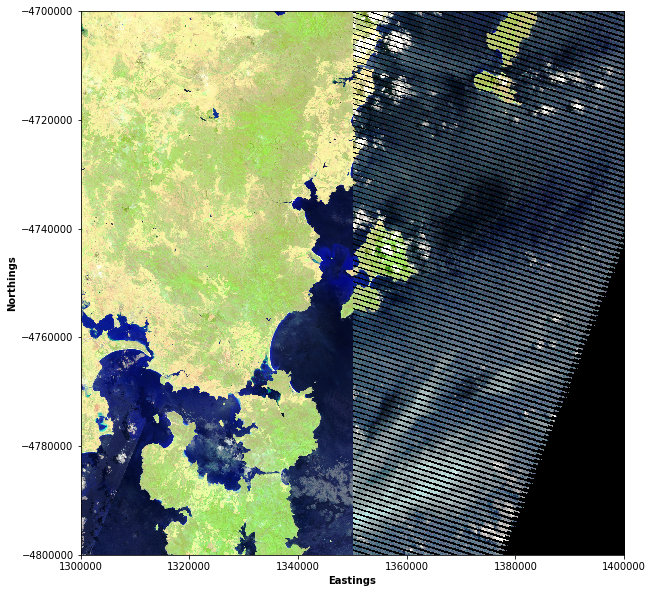

In [14]:
DEAPlotting.three_band_image(out, bands = ['swir1', 'nir', 'green'], contrast_enhance=True);

In [36]:
# This is the gold nugget
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [37]:
test = ds_m.sel(time=is_cm(ds_m['time.month']))
#ds_m['time.month']

In [38]:
test

<xarray.Dataset>
Dimensions:    (time: 6, x: 100, y: 100)
Coordinates:
  * y          (y) float64 -4.57e+06 -4.57e+06 -4.57e+06 ... -4.58e+06 -4.58e+06
  * x          (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.385e+06 1.385e+06
  * time       (time) datetime64[ns] 2018-01-18T23:53:47.500000 ... 2018-04-24T23:52:27.500000
Data variables:
    red        (time, y, x) float64 311.0 317.0 348.0 ... 274.0 300.0 387.0
    green      (time, y, x) float64 313.0 303.0 339.0 ... 297.0 323.0 302.0
    blue       (time, y, x) float64 172.0 184.0 200.0 ... 157.0 170.0 235.0
    nir        (time, y, x) float64 1.837e+03 1.818e+03 ... 2.079e+03 1.954e+03
    swir1      (time, y, x) float64 1.042e+03 1.294e+03 ... 922.0 1.044e+03
    swir2      (time, y, x) float64 510.0 585.0 627.0 ... 503.0 605.0 513.0
    data_perc  (time) float64 0.9076 0.7445 0.9815 0.8123 0.9999 0.7621
Attributes:
    crs:      EPSG:3577

In [39]:
dsm_gm = GeoMedian().compute(ds_m)

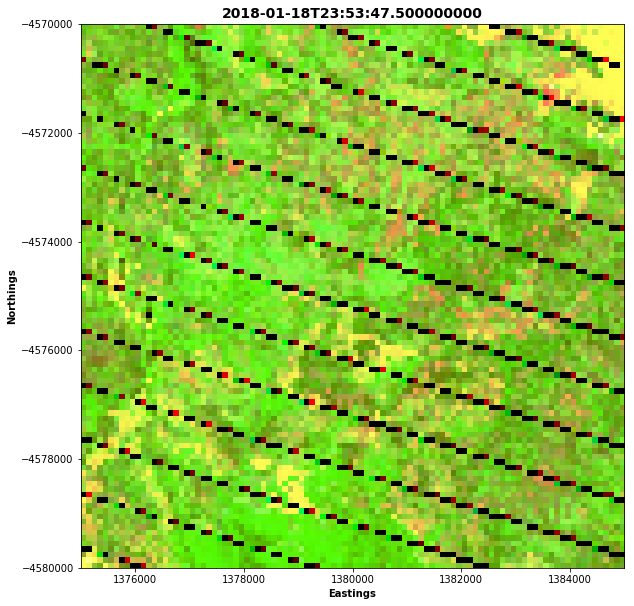

In [40]:
DEAPlotting.three_band_image(ds_m, bands = ['swir1', 'nir', 'green'], contrast_enhance=True);

In [ ]:
def multi_mgm(x, y):
    query = {'x': x,
             'y': y,
             #'time': time,
             'resolution': resolution,
             'crs': 'EPSG:3577'}

    # make new lists for just the months of interest
    cm_scenes = []

    for sensor in sensors:
        prod = sensor+'_'+deriv+'_albers'

        scenes = dc.find_datasets(product=prod, time=epoch, **query)

        for scene in scenes:
            #print(scene.center_time)
            if scene.center_time.month in cmonths:
                cm_scenes.append(scene)
                #print('Found candidate')
            #else:
                #print('No custom months found')
    print('CM-scenes contains '+ str(len(cm_scenes))+' scenes')

    # Add datasets list to the original query
    query = {'x': x,
             'y': y,
             #'time': time,
             'datasets': cm_scenes,
             'resolution': resolution,
             'crs': 'EPSG:3577'}

    dsm = DEADataHandling.load_clearlandsat(dc=dc, query=query, #remove query (just use datasets??)
                                           #product=product,
                                           masked_prop=0,
                                           #sensors = sensors, # maybe not needed
                                           bands_of_interest = bands, #mask_pixel_quality=True,
                                           ls7_slc_off=True)

    # compute geomedian
    #ds_mgm = GeoMedian().compute(dsm)
    #return ds_mgm.copy()
    return dsm.copy()

In [ ]:
xm, ym = (x[0]+x[1])/2, (y[0]+y[1])/2
x1, x2 = (x[0], xm), (xm, x[1])
y1, y2 = (y[0], ym), (ym, y[1])
if subset:
    out1 = multi_mgm(x1, y)
    out2 = multi_mgm(x2, y)
    out = xr.concat([out1, out2], dim='x')
else:
    out = multi_mgm(x, y)